<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/Maximization_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Maximization Bias in Q Learning

This is an example of the markov random process Example 6.7 in page-134 from the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).

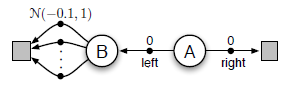

In [2]:
nodes = 4
num_actions = [10,2]
actions = [list(range(num_actions[0])),[-1,1]]
start = 2

In [3]:
def gaussian_reward():
  return np.random.normal(-0.1,1)

def target_policy(Q,current,epsilon):
  maxQ = np.max(Q[current-1])
  idx = np.where(Q[current-1] == maxQ)[0]
  action_prob = epsilon/float(num_actions[current-1])*np.ones((num_actions[current-1],))
  action_prob[idx] += (1-epsilon)/float(len(idx))
  act_idx = np.random.choice(range(num_actions[current-1]),p=action_prob)
  return act_idx

def step(current,act_idx):
  reward = 0
  if current == 1:
    next_state = 0
    reward = gaussian_reward()
  else:
    next_state = current + actions[current-1][act_idx]
  return next_state,reward

def QLearning(num_episodes,alpha,epsilon,gamma):
  Q = []
  for i in range(2):
    Q += [np.zeros((num_actions[i],))]
  stats = np.zeros((num_episodes,2))

  for episode in range(num_episodes):
    stats[episode,0] = episode + 1
    state_count = 0
    trans_count = 0
    current = start
    while current in [1,2]:
      act_idx = target_policy(Q,current,epsilon)
      next_state,reward = step(current,act_idx)
      if current == 2 and next_state == 1:
        trans_count += 1.0
      if next_state in [0,3]:
        best_nextQ = 0
      else:
        # print(next_state)#Q[next_state-1])
        best_nextQ = np.max(Q[next_state-1])
      Q[current-1][act_idx] += alpha*(reward + gamma*best_nextQ - Q[current-1][act_idx])
      current = next_state
    
    stats[episode,1] = trans_count
  return Q,stats

def doubleQLearning(num_episodes,alpha,epsilon,gamma):
  Q1 = []
  Q2 = []
  for i in range(2):
    Q1 += [np.zeros((num_actions[i],))]
    Q2 += [np.zeros((num_actions[i],))]
  stats = np.zeros((num_episodes,2))

  for episode in range(num_episodes):
    stats[episode,0] = episode + 1
    state_count = 0
    trans_count = 0
    current = start
    count = 0
    while current in [1,2]:
      act_idx = target_policy(Q1+Q2,current,epsilon)
      next_state,reward = step(current,act_idx)
      if current == 2 and next_state == 1:
        trans_count += 1.0
      if count%2 == 0:
        if next_state in [0,3]:
          best_nextQ = 0
        else:
          best_act_idx = np.argmax(Q1[next_state-1])
          best_nextQ = Q2[next_state-1][best_act_idx]
        Q1[current-1][act_idx] += alpha*(reward + gamma*best_nextQ - Q1[current-1][act_idx])
      else:
        if next_state in [0,3]:
          best_nextQ = 0
        else:
          best_act_idx = np.argmax(Q2[next_state-1])
          best_nextQ = Q1[next_state-1][best_act_idx]
        Q2[current-1][act_idx] += alpha*(reward + gamma*best_nextQ - Q2[current-1][act_idx])
      current = next_state
      count += 1
    
    stats[episode,1] = trans_count
  return Q1+Q2,stats

In [4]:
num_episodes = 300
num_runs = 1000
epsilon = 0.1
alpha = 0.5
gamma = 1
total_stats1 = np.zeros((num_episodes,2))
total_stats2 = np.zeros((num_episodes,2))
for i in tqdm(range(num_runs)):
  Q1,stats1 = QLearning(num_episodes,alpha,epsilon,gamma)
  Q2,stats2 = doubleQLearning(num_episodes,alpha,epsilon,gamma)
  total_stats1[:,1] += 100*stats1[:,1]/float(num_runs)
  total_stats2[:,1] += 100*stats2[:,1]/float(num_runs)

total_stats1[:,0] = stats1[:,0]
total_stats2[:,0] = stats2[:,0]

100%|██████████| 1000/1000 [00:54<00:00, 18.50it/s]


Text(0, 0.5, '% left transition from state A')

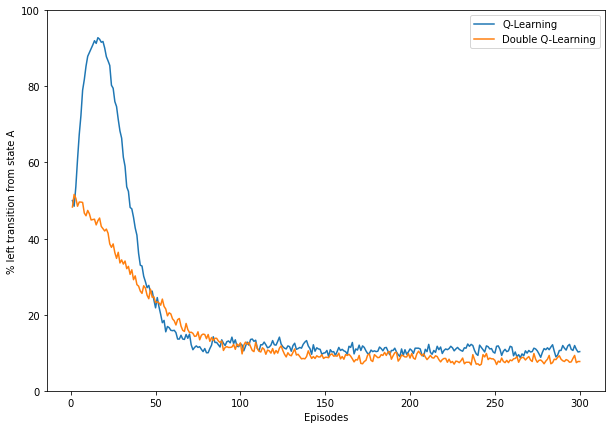

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(total_stats1[:,0],total_stats1[:,1])
ax.plot(total_stats2[:,0],total_stats2[:,1])
ax.set_ylim([0,100])
ax.legend(['Q-Learning','Double Q-Learning'])
ax.set_xlabel('Episodes')
ax.set_ylabel('% left transition from state A')